<a href="https://colab.research.google.com/github/shahd1995913/Tahalf-Mechine-Learning-DS3/blob/main/SVM/ML1_S6_Coding_Material(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML1_S6&S7 Coding Material
---
## Support Vector Machine (SVM)
---
- Implementation and hyperparameter tuning of Support Vector Machine in Python.

- For implementation on a dataset, we will be using the Income Evaluation dataset, which has information about an individual’s personal life and an output of 50K or <=50. The [dataset](https://www.kaggle.com/lodetomasi1995/income-classification) can be found here.

- The task here is to classify the income of an individual when given the required inputs about his personal life.

In [ ]:
#First, let’s import all required libraries.
#============================================
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Now let’s read the dataset and look at the columns to understand the information better.
df = pd.read_csv('./Data/income_evaluation.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# removing redundant spaces from column names
df.columns = list(map(lambda a: a.lstrip(), df.columns))

print('Check the data. Some values are missing.') if df.isnull().any().any() else print("There are no missing values in the data.")

There are no missing values in the data.


In [ ]:
df['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

There are question marks in the columns instead of 'NaN' or 'None' values. Question marks signalize missing values, that is why they will be removed.

In [ ]:
shape0 = df.shape[0]
for column in df.columns:
    df[column].replace(' ?', np.NaN, inplace=True)
df = df.dropna().reset_index().drop(columns=['index'])
shape1 = df.shape[0]
print(str(shape0 - shape1) + ' rows have been removed.')

2399 rows have been removed.


In [ ]:
df['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

In [ ]:
#1.1 Adjusting income column to binary type
#============================================
income = df.income.value_counts()
income

 <=50K    22654
 >50K      7508
Name: income, dtype: int64

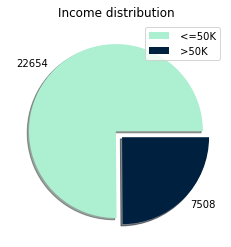

In [ ]:
colors = ['#ADEFD1FF', '#00203FFF']
explode = [0, 0.1]
plt.pie(income, labels=income.values, colors=colors, explode = explode, shadow=True)
plt.title('Income distribution')
plt.legend(labels=income.index)

In [ ]:
# changing string to binary values.
df['income'].replace([' <=50K',' >50K'],[1,0], inplace=True)

In [ ]:
#1.2 Creating correlation heatmap
#=====================================
# checking types of variables
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

In [ ]:
# object type variables cannot be included in a correlation heatmap.
stats = df.select_dtypes(['float', 'int64']).drop(columns=['income'])

<AxesSubplot:>

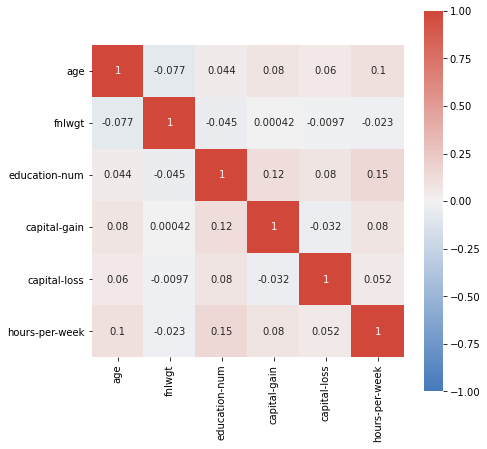

In [ ]:
fig = plt.figure(figsize=(7,7))
corr = stats.corr()
sns.heatmap(corr,
            vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(h_neg=250, h_pos=15, as_cmap=True),
            square=True, annot=True)

There is barely correlation between all numeric variables.

In [ ]:
#1.2 Creating density functions and boxplots
#=============================================
stats.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,30162.0,38.437902,13.134665,17.0,28.00,37.0,47.0,90.0
fnlwgt,30162.0,189793.833930,105652.971529,13769.0,117627.25,178425.0,237628.5,1484705.0
education-num,30162.0,10.121312,2.549995,1.0,9.00,10.0,13.0,16.0
capital-gain,30162.0,1092.007858,7406.346497,0.0,0.00,0.0,0.0,99999.0
capital-loss,30162.0,88.372489,404.298370,0.0,0.00,0.0,0.0,4356.0
hours-per-week,30162.0,40.931238,11.979984,1.0,40.00,40.0,45.0,99.0


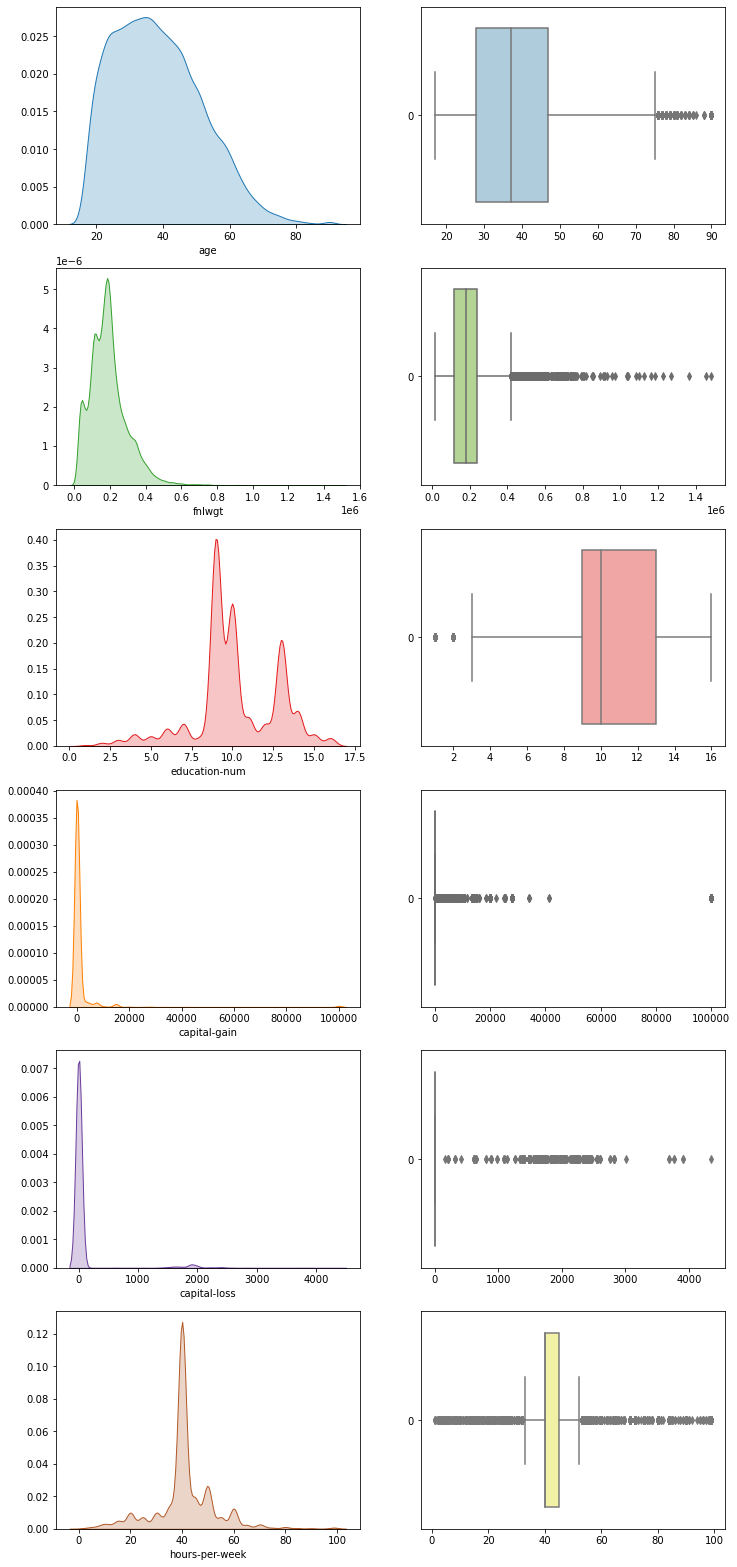

In [ ]:
# creating graphs
colors = list(sns.color_palette("Paired"))
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12,28))
for i in range(6):
    # Plot univariate or bivariate distributions using kernel density estimation.
    sns.kdeplot(stats.iloc[:, i], 
                shade = True, 
                color = colors[i*2+1], 
                ax=ax[i, 0]).set(ylabel = '', xlabel = stats.columns[i])
    
    sns.boxplot(data=stats.iloc[:, i],
                color = colors[i*2], orient="h",
                ax=ax[i, 1]).set(xlabel = '', ylabel = '')
plt.show()

In [ ]:
# 2. Standardization and preparing variables
# Convert categorical variable into dummy/indicator variables.
df_final = pd.get_dummies(df)
df_final.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


- Now for training and testing our model, the data has to be divided into train and test data.
- We will also scale the data to lie between 0 and 1.

In [ ]:
# Split dataset into test and train data
X = df_final.drop(columns=['income'])
y = df_final['income']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

Now let’s go ahead with defining the Support vector Classifier along with its hyperparameters. Next, we will fit this model on the training data.

In [ ]:
#Define support vector classifier with hyperparameters
svc = SVC(random_state=101)
# Evaluate a score by cross-validation. (cvint, Determines the cross-validation splitting strategy.)
accuracies = cross_val_score(svc,X_train,y_train,cv=5)
svc.fit(X_train,y_train)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X_test,y_test))

Train Score: 0.7843673366844961
Test Score: 0.7916459472899056


- The model has been trained and we can now observe the outputs as well.
- Below, you can see the accuracy of the test and train dataset
- You can even hyper tune your model by the following code:

In [ ]:
grid = {
   'C':[0.01,0.1,1,10],
   'kernel' : ["linear","poly","rbf","sigmoid"],
   'degree' : [1,3,5,7],
   'gamma' : [0.01,1]
}
svm  = SVC ()
# GridSearchCV is a useful tool to fine tune the parameters of your model.
# The “best” parameters that GridSearchCV identifies are technically the best that could be produced
svm_cv = GridSearchCV(svm, grid, cv = 5)
svm_cv.fit(X_train,y_train)
print("Best Parameters:",svm_cv.best_params_)
print("Train Score:",svm_cv.best_score_)
print("Test Score:",svm_cv.score(X_test,y_test))